In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from efficientnet_pytorch import EfficientNet

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import cv2
plt.style.use('ggplot')
from IPython.display import Video
from IPython.display import HTML
import face_recognition
from PIL import Image, ImageDraw
from tqdm import tqdm

In [3]:
train_sample_metadata = pd.read_json('./input/deepfake-detection-challenge/train_sample_videos/metadata.json').T
train_sample_metadata.head()

,label,split,original
aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
abarnvbtwb.mp4,REAL,train,None
abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


In [20]:
input_dir = './output/deepfake-detection-challenge/train_sample_videos/'
real_dirs = []
fake_dirs = []
for i in range(len(train_sample_metadata)):
    fn = train_sample_metadata.index[i]
    label = train_sample_metadata.iloc[i,0]
    fn_dir = input_dir+fn+'/'
    if label=='REAL':
        real_dirs.append(fn_dir)
    else:
        fake_dirs.append(fn_dir)

In [99]:
class CustomDataset(Dataset):
    def __init__(self, real_dirs, fake_dirs, transform=None):
        self.image_list = []
        self.label_list = []
        self.transform = transform
        
        for directory in real_dirs:
            for filename in os.listdir(directory):
                if filename.endswith('.jpg'):
                    self.image_list.append(os.path.join(directory, filename))
                    self.label_list.append(0)
                    
        for directory in fake_dirs:
            for filename in os.listdir(directory):
                if filename.endswith('.jpg'):
                    self.image_list.append(os.path.join(directory, filename))
                    self.label_list.append(1)
    
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, index):
        image = Image.open(self.image_list[index]).convert('RGB')
        image = image.resize((224, 224))
        label = self.label_list[index]
        if self.transform:
            image = self.transform(image)
        return image, label

In [100]:
train_transforms = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(20),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
#     transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [101]:
train_dataset = CustomDataset(real_dirs, fake_dirs, transform=train_transforms)
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(train_dataset, test_size=0.2)

In [102]:
BATCH_SIZE = 32
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [103]:
model = EfficientNet.from_pretrained('efficientnet-b0')

Loaded pretrained weights for efficientnet-b0


In [104]:
def display_model(model):
    # Check number of parameters 
    summary_dict = {}
    num_params = 0
    summary_str = ['='*80]

    for module_name, module in model.named_children():
        summary_count = 0
        for name, param in module.named_parameters():
            if(param.requires_grad):
                summary_count += param.numel()
                num_params += param.numel()
        summary_dict[module_name] = [summary_count]
        summary_str+= [f'- {module_name: <40} : {str(summary_count):^34s}']

    summary_dict['total'] = [num_params]

    # print summary string
    summary_str += ['='*80]
    summary_str += ['--' +  f'{"Total":<40} : {str(num_params) + " params":^34s}' +'--']
    print('\n'.join(summary_str))

    # print model structure
    print(model)

In [105]:
model._fc = torch.nn.Linear(num_features, 1)

In [106]:
for param in model.parameters():
    param.requires_grad = False
for param in model._fc.parameters():
    param.requires_grad = True

In [107]:
display_model(model)

- _conv_stem                               :                 0                 
- _bn0                                     :                 0                 
- _blocks                                  :                 0                 
- _conv_head                               :                 0                 
- _bn1                                     :                 0                 
- _avg_pooling                             :                 0                 
- _dropout                                 :                 0                 
- _fc                                      :                1281               
- _swish                                   :                 0                 
--Total                                    :            1281 params            --
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001,

In [156]:
def train(train_loader, model, criterion, optimizer):
    """
    Train network
    :param train_loader: training dataloader
    :param model: model to be trained
    :param criterion: criterion used to calculate loss (should be CrossEntropyLoss from torch.nn)
    :param optimizer: optimizer for model's params (Adams or SGD)
    :return: mean training loss
    """
    model.train()
    loss_ = 0.0
    losses = []
    # TO DO: read this documentation and then uncomment the line below; https://pypi.org/project/tqdm/
    it_train = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training ...", position = 0) # progress bar
    for i, (images, labels) in it_train:
        # TO DO: read/understand and then uncomment these lines
        images, labels = images.to(device), labels.view(-1, 1).to(device).float()
        optimizer.zero_grad()
        prediction = model(images)
        loss = criterion(prediction, labels)
        it_train.set_description(f'loss: {loss:.3f}')
        loss.backward()
        optimizer.step()
        losses.append(loss)

    return torch.stack(losses).mean().item()

def test(test_loader, model, criterion):
    """
    Test network.
    :param test_loader: testing dataloader
    :param model: model to be tested
    :param criterion: criterion used to calculate loss (should be CrossEntropyLoss from torch.nn)
    :return: mean_accuracy: mean accuracy of predicted labels
             test_loss: mean test loss during testing
    """
    model.eval()
    losses = []
    correct = 0
    total = 0
    # TO DO: read this documentation and then uncomment the line below; https://pypi.org/project/tqdm/
    it_test = tqdm(enumerate(test_loader), total=len(test_loader), desc="Validating ...", position = 0)
    for i, (images, labels) in it_test:
        
        # TO DO: read/understand and then uncomment these lines
        images, labels = images.to(device), labels.view(-1, 1).to(device).float()
        with torch.no_grad():  # https://pytorch.org/docs/stable/generated/torch.no_grad.html
            output = model(images)
            preds = torch.round(torch.sigmoid(output)).type(torch.int)
            loss = criterion(output, labels)
            losses.append(loss.item())
            correct += (preds == labels).sum().item()
            total += len(labels)
    mean_accuracy = correct / total
    test_loss = np.mean(losses)
    print('Mean Accuracy: {0:.4f}'.format(mean_accuracy))
    print('Avg loss: {}'.format(test_loss))
        
    return mean_accuracy, test_loss   

In [159]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [160]:
train_losses = []
train_accuracy_list = []
test_losses = []
test_accuracy_list = []
test_interval = 5

# Iterate over the DataLoader for training data
for epoch in tqdm(range(num_epochs), total=num_epochs, desc="Training ...", position=1): 
    train_loss = train(train_loader, model, criterion, optimizer) # Train the Network for one epoch
    # TO DO: uncomment the line below. It should be called each epoch to apply the lr_scheduler
    scheduler.step() 
    train_losses.append(train_loss)
    print(f'Loss for Training on epoch {str(epoch)} is {str(train_loss)} \n')
    
    if(epoch%test_interval==0 or epoch==1 or epoch==num_epochs-1):
        print('Evaluating Network')

        train_accuracy, _ = test(train_loader, model, criterion) # Get training accuracy
        train_accuracy_list.append(train_accuracy)

        print(f'Training accuracy on epoch {str(epoch)} is {str(train_accuracy)} \n')

        test_accuracy, test_loss = test(test_loader, model, criterion) # Get testing accuracy and error
        test_losses.append(test_loss)
        test_accuracy_list.append(test_accuracy)

        print(f'Testing accuracy on epoch {str(epoch)} is {str(test_accuracy)} \n')


loss: 0.201: 100%|███████████████████████████████████████████████████████████████████| 269/269 [00:20<00:00, 13.05it/s]


Loss for Training on epoch 0 is 0.2891252934932709 

Evaluating Network


Validating ...: 100%|████████████████████████████████████████████████████████████████| 269/269 [00:18<00:00, 14.59it/s]


Mean Accuracy: 0.9141
Avg loss: 0.23019946588127144
Training accuracy on epoch 0 is 0.9141425908667288 



Validating ...: 100%|██████████████████████████████████████████████████████████████████| 68/68 [00:04<00:00, 14.70it/s]

Training ...:  10%|██████▉                                                              | 1/10 [00:43<06:33, 43.69s/it]

Mean Accuracy: 0.8952
Avg loss: 0.25880150677745833
Testing accuracy on epoch 0 is 0.8952026082906381 



loss: 0.744: 100%|███████████████████████████████████████████████████████████████████| 269/269 [00:20<00:00, 13.29it/s]


Loss for Training on epoch 1 is 0.28148093819618225 

Evaluating Network


Validating ...: 100%|████████████████████████████████████████████████████████████████| 269/269 [00:18<00:00, 14.60it/s]


Mean Accuracy: 0.9188
Avg loss: 0.22449361735117038
Training accuracy on epoch 1 is 0.9188024231127679 



Validating ...: 100%|██████████████████████████████████████████████████████████████████| 68/68 [00:04<00:00, 14.65it/s]

Training ...:  20%|█████████████▊                                                       | 2/10 [01:27<05:47, 43.48s/it]

Mean Accuracy: 0.8957
Avg loss: 0.2544207777827978
Testing accuracy on epoch 1 is 0.895668374476013 



loss: 0.196: 100%|███████████████████████████████████████████████████████████████████| 269/269 [00:20<00:00, 13.26it/s]

Training ...:  30%|████████████████████▋                                                | 3/10 [01:47<03:50, 32.90s/it]

Loss for Training on epoch 2 is 0.28202202916145325 



loss: 0.273: 100%|███████████████████████████████████████████████████████████████████| 269/269 [00:20<00:00, 13.35it/s]

Training ...:  40%|███████████████████████████▌                                         | 4/10 [02:07<02:47, 27.87s/it]

Loss for Training on epoch 3 is 0.27747243642807007 



loss: 0.498: 100%|███████████████████████████████████████████████████████████████████| 269/269 [00:20<00:00, 13.39it/s]

Training ...:  50%|██████████████████████████████████▌                                  | 5/10 [02:27<02:05, 25.07s/it]

Loss for Training on epoch 4 is 0.2742612659931183 



loss: 0.240: 100%|███████████████████████████████████████████████████████████████████| 269/269 [00:20<00:00, 13.45it/s]


Loss for Training on epoch 5 is 0.2715817093849182 

Evaluating Network


Validating ...: 100%|████████████████████████████████████████████████████████████████| 269/269 [00:18<00:00, 14.63it/s]


Mean Accuracy: 0.9243
Avg loss: 0.20917992014091696
Training accuracy on epoch 5 is 0.924277726001864 



Validating ...: 100%|██████████████████████████████████████████████████████████████████| 68/68 [00:04<00:00, 14.57it/s]

Training ...:  60%|█████████████████████████████████████████▍                           | 6/10 [03:10<02:04, 31.19s/it]

Mean Accuracy: 0.9036
Avg loss: 0.24098982659223325
Testing accuracy on epoch 5 is 0.9035863996273871 



loss: 1.084: 100%|███████████████████████████████████████████████████████████████████| 269/269 [00:20<00:00, 13.30it/s]

Training ...:  70%|████████████████████████████████████████████████▎                    | 7/10 [03:30<01:22, 27.61s/it]

Loss for Training on epoch 6 is 0.2733205258846283 



loss: 0.214: 100%|███████████████████████████████████████████████████████████████████| 269/269 [00:20<00:00, 13.17it/s]

Training ...:  80%|███████████████████████████████████████████████████████▏             | 8/10 [03:51<00:50, 25.32s/it]

Loss for Training on epoch 7 is 0.2733212113380432 



loss: 0.226: 100%|███████████████████████████████████████████████████████████████████| 269/269 [00:20<00:00, 13.36it/s]

Training ...:  90%|██████████████████████████████████████████████████████████████       | 9/10 [04:11<00:23, 23.70s/it]

Loss for Training on epoch 8 is 0.27447178959846497 



loss: 0.107: 100%|███████████████████████████████████████████████████████████████████| 269/269 [00:20<00:00, 13.38it/s]


Loss for Training on epoch 9 is 0.2661370038986206 

Evaluating Network


Validating ...: 100%|████████████████████████████████████████████████████████████████| 269/269 [00:18<00:00, 14.52it/s]


Mean Accuracy: 0.9247
Avg loss: 0.20731957339885954
Training accuracy on epoch 9 is 0.9247437092264679 



Validating ...: 100%|██████████████████████████████████████████████████████████████████| 68/68 [00:04<00:00, 14.87it/s]

Training ...: 100%|████████████████████████████████████████████████████████████████████| 10/10 [04:54<00:00, 29.47s/it]

Mean Accuracy: 0.9045
Avg loss: 0.23983770992387743
Testing accuracy on epoch 9 is 0.9045179319981369 



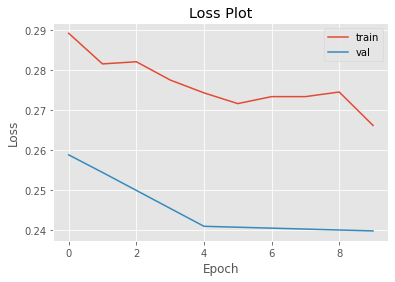

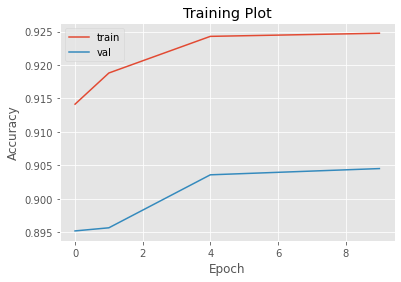

In [162]:
def plot_losses(train, val, test_frequency, num_epochs):
    plt.plot(train, label="train")
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0 or i == 1)]
    plt.plot(indices, val, label="val")
    plt.title("Loss Plot")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()
    
def plot_accuracy(train, val, test_frequency, num_epochs):
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0 or i == 1)]
    plt.plot(indices, train, label="train")
    plt.plot(indices, val, label="val")
    plt.title("Training Plot")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()
plot_losses(train_losses, test_losses, test_interval, num_epochs)
plot_accuracy(train_accuracy_list, test_accuracy_list, test_interval, num_epochs)

In [211]:
import random
def eval_example(model, dirs):
    model.eval()
    image_path = random.choice(dirs)+'0.jpg'
    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)
    plt.show()
    image = image.resize((224, 224))
    image = train_transforms(image).unsqueeze(0).to(device)
    output = model(image)
    pred = torch.sigmoid(output).item()
    print(output.item())
    if pred>0.5:
        print('Prediction: FAKE')
    else:
        print('Prediction: REAL')

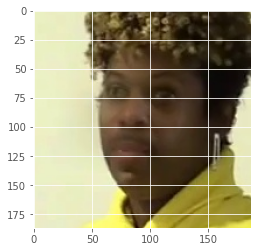

2.027967691421509
Prediction: FAKE


In [225]:
f = eval_example(model, fake_dirs)

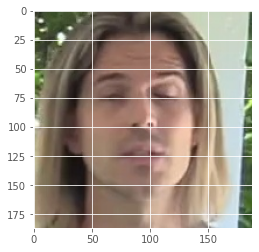

-0.020525962114334106
Prediction: REAL


In [227]:
r = eval_example(model, real_dirs)